In [101]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
import os

os.chdir("/home/weedsci/matt/SemiF-AnnotationPipeline/")
from semif_utils.utils import make_exg, exact_color
import numpy as np
import matplotlib.pyplot as plt
from hydra import initialize, compose
from omegaconf import OmegaConf
from PIL import Image
from pathlib import Path
import pandas as pd
import cv2
import random
import sys
from PIL import Image, ImageStat
from scipy import stats
import numpy.ma as ma

sys.path.append("/home/weedsci/matt/SemiF-SyntheticPipeline/")
from synth_utils.config_utils import read_cutouts, sort_cutouts

## Initialize Hydra Configuration

In [39]:
with initialize(version_base=None,
                config_path="../../SemiF-SyntheticPipeline/conf"):
    cfg = compose(config_name="config.yaml", return_hydra_config=True)
    cfg.general.workdir = '${hydra.runtime.cwd}'
    cfg.data.cutoutdir = "/media/hdd1/mkutu/wir/semifield-cutouts"

### Configure cutout sorting

In [40]:
# Change hydra config manually
cfg.cutouts.features.dap.min = 0
cfg.cutouts.features.dap.max = 30
cfg.cutouts.features.is_primary = True
cfg.cutouts.features.extends_border = False
cfg.cutouts.features.green_sum.max = 10000000
cfg.cutouts.features.green_sum.min = 500000
cfg.cutouts.features.area.max = None
cfg.cutouts.features.area.min = 25
alldf = read_cutouts(cfg.data.cutoutdir)
df = sort_cutouts(alldf, cfg, save_csv=False)
df["path"] = cfg.data.cutoutdir + "/" + df["cutout_path"]
cutpaths = df["path"]
print("Total cutouts after sorting: ", len(df))


Done filtering cutouts...
Total cutouts after sorting:  55


### Choose a random cutouts

In [215]:
# Get img and mask paths
cutp = random.choice(list(cutpaths))
cutp

'/media/hdd1/mkutu/wir/semifield-cutouts/MD_2022-08-15/MD_1660586115_0.png'

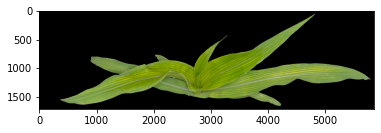

In [219]:
# Show cutouts
img = cv2.cvtColor(cv2.imread(str(cutp)), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


In [248]:
image_copy = img.copy()
# Mask out zero values for descriptive stats
black_pixels_mask = np.all(img == [0, 0, 0], axis=-1)
non_black_pixels_mask = ~black_pixels_mask
image_copy[black_pixels_mask] = [1, 1, 1]
image_copy[non_black_pixels_mask] = [0, 0, 0]
maimg = ma.array(img, mask=image_copy)

# Get descriptive stats for each channel
channels = ["r", "g", "b"]
for idx, c in enumerate(channels):
    scipy_desc = stats.describe(maimg[...,idx].flatten())
    rec_key = f"channel_{c}"
    rec = pd.DataFrame(maimg[...,idx].flatten(), columns=[rec_key]).describe().to_dict()
    rec[rec_key]["variance"] = scipy_desc.variance
    rec[rec_key]["skewness"] = scipy_desc.skewness
    rec[rec_key]["kurtosis"] = scipy_desc.kurtosis
    print(rec)
    

154.52925300630116
{'channel_r': {'count': 2666649.0, 'mean': 125.92075222498349, 'std': 18.979187925157426, 'min': 0.0, '25%': 114.0, '50%': 125.0, '75%': 136.0, 'max': 255.0, 'variance': 3186.7733058852446, 'skewness': 1.1693715795795696, 'kurtosis': -0.4528043310994483}}
{'channel_g': {'count': 2666649.0, 'mean': 154.52925300630116, 'std': 15.994583275061514, 'min': 2.0, '25%': 145.0, '50%': 155.0, '75%': 164.0, 'max': 255.0, 'variance': 4723.229542262256, 'skewness': 1.1100470626240528, 'kurtosis': -0.6993178496476995}}
{'channel_b': {'count': 2666649.0, 'mean': 49.562688602811996, 'std': 35.177280137222795, 'min': 0.0, '25%': 2.0, '50%': 60.0, '75%': 76.0, 'max': 255.0, 'variance': 807.2848800764639, 'skewness': 1.9585318775241112, 'kurtosis': 2.595153196180936}}


In [107]:
# dfdescribe = pd.DataFrame(img).describe()
# dfdescribe

statd = stats.describe(maimg[..., 0].ravel())
statd

DescribeResult(nobs=2983750, minmax=(0, 255), mean=48.608211478843735, variance=3536.677961387019, skewness=0.4973027351926977, kurtosis=-1.5669792430629343)

DescribeResult(nobs=12617766, minmax=(0, 255), mean=52.26928277160949, variance=3545.722615080454, skewness=0.3690172820609342, kurtosis=-1.6646242369446285)

In [ ]:
im = Image.open(cutp).convert("RGB")
stat = ImageStat.Stat(im)
print("extrema: ", stat.extrema)
print("count: ", stat.count)
print("sum: ", stat.sum)
print("sum2: ", stat.sum2)
print("mean: ", stat.mean)
print("median: ", stat.median)
print("rms: ", stat.rms)

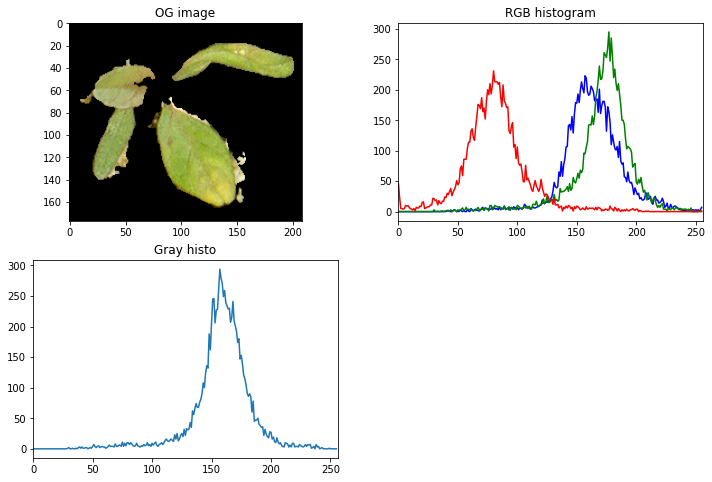

Kurtosis 2.3462773385734503


In [204]:
from skimage import color  # skimage is an image processing library
from scipy import ndimage, stats, signal  # scipy provides scientific computing functions

imgp = "/media/hdd1/mkutu/wir/semifield-cutouts/NC_2022-09-15/NC_1663247218_1.png"
imgp_mask = "/media/hdd1/mkutu/wir/semifield-cutouts/NC_2022-09-15/NC_1663247218_1_mask.png"
# imgp = "/media/hdd1/mkutu/wir/semifield-cutouts/MD_2022-08-24/MD_1661357971_3.png"
# imgp_mask = "/media/hdd1/mkutu/wir/semifield-cutouts/MD_2022-08-24/MD_1661357971_3_mask.png"
imgp = "/media/hdd1/mkutu/wir/semifield-cutouts/MD_2022-07-20/MD_1658328430_8.png"
imgp_mask = "/media/hdd1/mkutu/wir/semifield-cutouts/MD_2022-07-20/MD_1658328430_8_mask.png"

img = cv2.cvtColor(cv2.imread(str(imgp)), cv2.COLOR_BGR2RGB).astype(np.uint8)
mask = cv2.imread(str(imgp_mask))[..., 0]
fig = plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(img)
plt.title("OG image")

color = ('b', 'g', 'r')
plt.subplot(222)
for i, col in enumerate(color):
    histr = cv2.calcHist([img], [i], mask, [256], [0, 256])
    plt.plot(histr, color=col)
    plt.xlim([0, 256])
plt.title("RGB histogram")

fgrayIm = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
grayhistr = cv2.calcHist([fgrayIm], [0], mask, [256], [0, 256])
plt.subplot(223)
plt.plot(grayhistr)
plt.xlim([0, 256])
plt.title("Gray histo")
plt.show()
plt.close()

print('Kurtosis',
      stats.kurtosis(fgrayIm.flatten(), fisher=False, nan_policy="omit"))

(177, 208)


4

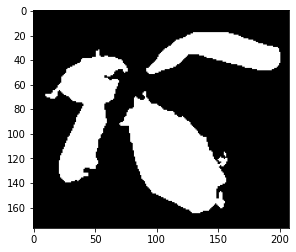

In [290]:
from skimage.util import img_as_float
from skimage.measure import label
# print(img_as_float(img))
plt.imshow(mask, cmap="gray")
print(mask.shape)
labels, num = label(mask, background=0, connectivity=2, return_num=True)
num

256
163


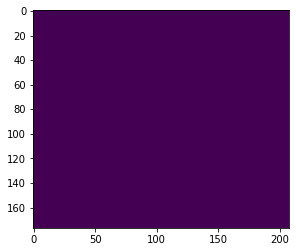

15
182
0
255


2.7258887100507097

In [274]:
from skimage.measure import shannon_entropy
import numpy as np
import numpy.ma as ma

ch3_mask = cv2.imread(str(imgp_mask))[..., 0]
ch3_mask = np.where(ch3_mask == 0, True, False)

y = make_exg(img)
y = ma.array(y, mask=ch3_mask)
plt.imshow(np.where(y == 0, y, 0))

# distribution of exg
marg = np.histogramdd(np.ravel(y), bins=256)[0] / y.size

print(len(marg))
# plt.plot(marg)
# Filter zeros
marg = list(filter(lambda p: p > 0, np.ravel(marg)))
print(len(marg))
# plt.plot(marg)
# plt.imshow(y)
plt.show()
# sum values
entropy = -np.sum(np.multiply(marg, np.log2(marg)))

print(np.amin(y))
print(np.amax(y))
print(np.amin(img))
print(np.amax(img))
shannon_entropy(y)

In [3]:
resized_width = img.shape[1]
tolerance = 12
zoom = 2

cos = exact_color(imgp,
                  resized_width,
                  tolerance,
                  zoom,
                  save=False,
                  show=False,
                  ignore_black=True,
                  return_colors=True,
                  transparent=False)
cos

In [4]:
import seaborn as sns

cos["occurence"] = cos["occurence"].astype(np.uint16)
sns.catplot(data=cos,
            x="hex",
            y="occurence",
            kind="bar",
            height=12,
            palette=cos["hex"])


KeyError: 'hex'

In [47]:
coldict = cos.to_dict(orient="records")
coldict

[{'c_code': '#83A13F', 'occurence': 35217},
 {'c_code': '#AAB849', 'occurence': 23208},
 {'c_code': '#A2A54C', 'occurence': 54325},
 {'c_code': '#C8CF4D', 'occurence': 21880},
 {'c_code': '#BCC66F', 'occurence': 19998},
 {'c_code': '#67832E', 'occurence': 6052},
 {'c_code': '#415B00', 'occurence': 49051},
 {'c_code': '#818741', 'occurence': 43963},
 {'c_code': '#99A900', 'occurence': 33860},
 {'c_code': '#FFFEA1', 'occurence': 33781},
 {'c_code': '#1D1C00', 'occurence': 29602}]